## Investment Assignment

### Basics

In [1]:
# import all needed libraries

import numpy as np
import pandas as pd 
import chardet as cdet
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

### Solve for file encoding issues

Python default encoding gave error as read_csv was executed, so need to find out correct encoding

In [2]:
# first check encoding in companies file

companies = open("./companies.txt", "rb").read()
result1 = cdet.detect(companies)

# then check encoding in rounds2 file

rounds = open("./rounds2.csv", "rb").read()
result2 = cdet.detect(rounds)

# print results of chardet package

print(result1)
print(result2)

{'encoding': 'Windows-1254', 'confidence': 0.461086087463078, 'language': 'Turkish'}
{'encoding': 'Windows-1254', 'confidence': 0.4186155476629225, 'language': 'Turkish'}


### Read in the given datasets into Python

Using the right encoding -- i.e. iso8859_9, corresponding to Windows-1254 derived above and documentation on Python.org, here https://docs.python.org/2.4/lib/standard-encodings.html

In [3]:
# read input data into dataframes

orig_company_data = pd.read_csv("./companies.txt", encoding='ISO-8859-9', delimiter="\t", header=0)
orig_fund_rounds_data = pd.read_csv("./rounds2.csv", encoding='ISO-8859-9', header=0) 

### Initial Note on Data Quality

- Column 'permalink' is filled in each row of 'companies' dataset; column 'company_permalink' is filled in each row of 'rounds2' dataset
- Column 'funding_round_code' in the rounds2 dataset has too many nulls ~73%, exclude it from analysis
- Other columns with < 100% filling can be treated depending upon the analysis need later

In [4]:
orig_company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
permalink        66368 non-null object
name             66367 non-null object
homepage_url     61310 non-null object
category_list    63220 non-null object
status           66368 non-null object
country_code     59410 non-null object
state_code       57821 non-null object
region           58338 non-null object
city             58340 non-null object
founded_at       51147 non-null object
dtypes: object(10)
memory usage: 5.1+ MB


In [5]:
orig_fund_rounds_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


In [6]:
# % filled values (1 - % missing values) by column

print(orig_company_data.count()/orig_company_data['permalink'].count()*100)
print('\n')
print(orig_fund_rounds_data.count()/orig_fund_rounds_data['company_permalink'].count()*100)

permalink        100.000000
name              99.998493
homepage_url      92.378857
category_list     95.256750
status           100.000000
country_code      89.516032
state_code        87.121806
region            87.900796
city              87.903809
founded_at        77.065755
dtype: float64


company_permalink          100.000000
funding_round_permalink    100.000000
funding_round_type         100.000000
funding_round_code          27.090275
funded_at                  100.000000
raised_amount_usd           82.609679
dtype: float64


### Clean Up
- while working on question 4, observed that 'permalink' and 'company_permalink' columns have variations in case, because of which the merge fails even for the first permalink '/Organization/-Fame' which appears as '/organization/-fame' in rounds2 dataset
- hence change both columns into their lowercase versions

In [7]:
orig_company_data['permalink'] = orig_company_data['permalink'].str.lower()
orig_fund_rounds_data['company_permalink'] = orig_fund_rounds_data['company_permalink'].str.lower()

### Primary Keys
- based on above steps, we know **companies** dataset has 66368 observations and **rounds2** dataset has 114949
- checking for unique column values in each dataset we have **'permalink'** field in **companies** dataset with unique entries in each row; similarly, **'funding_round_permalink'** in **rounds2** dataset
- so these two columns are the primary keys of each of these datasets

In [8]:
print(orig_company_data.nunique())
print('\n')
print(orig_fund_rounds_data.nunique())

permalink        66368
name             66102
homepage_url     61191
category_list    27296
status               4
country_code       137
state_code         311
region            1092
city              5111
founded_at        3978
dtype: int64


company_permalink           66370
funding_round_permalink    114949
funding_round_type             14
funding_round_code              8
funded_at                    5033
raised_amount_usd           22095
dtype: int64


### Checkpoint 1: Data Cleaning

#### Question 1
How many unique companies are present in rounds2?
#### Answer 1
66370, since there are as many unique "company_permalink" values in the rounds2 dataset, which as per problem statement uniquely identifies companies in dataset

In [9]:
orig_fund_rounds_data['company_permalink'].nunique()

66370

#### Question 2
How many unique companies are present in companies?
#### Answer 2
66368, since there are as many unique "permalink" values in the companies dataset, which as per problem statement uniquely identifies companies in dataset

In [10]:
orig_company_data['permalink'].nunique()

66368

#### Question 3
In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.

#### Answer 3
"permalink" (derived above -- pls see "Primary Key" section)

##### Question 4
Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N

#### Answer 4
Y, 7 such 'company_permalink' were found

In [11]:
orig_fund_rounds_data['company_permalink']\
[~orig_fund_rounds_data['company_permalink'].isin(orig_company_data['permalink'])]

29597                               /organization/e-cãbica
31863          /organization/energystone-games-çµç³æ¸¸æ
45176                  /organization/huizuche-com-æ ç§ÿè½¦
58473                /organization/magnet-tech-ç£ç³ç§æ
101036    /organization/tipcat-interactive-æ²èÿä¿¡æ¯ç...
109969               /organization/weiche-tech-åè½¦ç§æ
113839                   /organization/zengame-ç¦
æ¸¸ç§æ
Name: company_permalink, dtype: object

##### Question 5
Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame?

#### Answer 5
114949

In [12]:
master_frame = pd.merge(orig_fund_rounds_data, orig_company_data, \
                        left_on='company_permalink', right_on='permalink', how='left')
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 16 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
permalink                  114942 non-null object
name                       114941 non-null object
homepage_url               108810 non-null object
category_list              111535 non-null object
status                     114942 non-null object
country_code               106271 non-null object
state_code                 104003 non-null object
region                     104782 non-null object
city                       104785 non-null object
founded_at                 94422 non-null object
dtypes: float64(1), object(15)
memory usage: 14.9+ MB


### Checkpoint 2: Funding Type Analysis

#### Data Prep
- Based on constraints shared, must exclude all funding types other than venture, angel, seed, and private equity
- Check for missing values of raised_amount_usd, since that is one of the fields to be analysed
- Based on the box chart, raised_amount_usd appears to be skewed towards higher values across funding types
- Hence, missing values of raised_amount_usd to be imputed with median

funding_round_type
angel             79.750574
private_equity    84.726477
seed              77.326039
venture           90.510686
dtype: float64
                      count          mean           std  min         25%  \
funding_round_type                                                         
angel                4860.0  9.586945e+05  7.404397e+06  0.0   150000.00   
private_equity       1936.0  7.330859e+07  1.981135e+08  0.0  5000000.00   
seed                23603.0  7.198180e+05  2.221733e+06  0.0    55000.00   
venture             50228.0  1.174895e+07  8.635207e+07  0.0  1600901.75   

                           50%         75%           max  
funding_round_type                                        
angel                 400000.0   1000000.0  4.945120e+08  
private_equity      20000000.0  75000000.0  4.745460e+09  
seed                  275000.0   1000000.0  2.000000e+08  
venture              5000000.0  12000000.0  1.760000e+10  


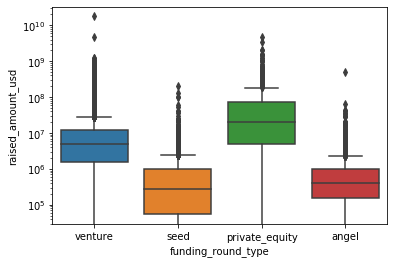

funding_round_type
angel             100.0
private_equity    100.0
seed              100.0
venture           100.0
dtype: float64


/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# filter for needed funding types
master_frame = master_frame[master_frame['funding_round_type'].isin(['venture', 'seed', 'angel', 'private_equity'])]

# review funding amount statistics by funding type

grouped_frame = master_frame.groupby('funding_round_type')

print(grouped_frame.raised_amount_usd.count() / grouped_frame.funding_round_permalink.count() * 100) # check %rows with filled raised_amount_usd, or 100 - %rows with missing values

print(grouped_frame.raised_amount_usd.describe())

sns.boxplot(x='funding_round_type', y='raised_amount_usd', data=master_frame)
plt.yscale('log')
plt.show()

# impute missing values with median, since box chart shows that raised_amount_usd appears to be skewed towards higher values across funding types
master_frame['raised_amount_usd']\
[(master_frame['funding_round_type'] == 'angel') & (master_frame['raised_amount_usd'].isnull() == True)] = \
grouped_frame.raised_amount_usd.median()['angel']

master_frame['raised_amount_usd']\
[(master_frame['funding_round_type'] == 'private_equity') & (master_frame['raised_amount_usd'].isnull() == True)] = \
grouped_frame.raised_amount_usd.median()['private_equity']

master_frame['raised_amount_usd']\
[(master_frame['funding_round_type'] == 'seed') & (master_frame['raised_amount_usd'].isnull() == True)] = \
grouped_frame.raised_amount_usd.median()['seed']

master_frame['raised_amount_usd']\
[(master_frame['funding_round_type'] == 'venture') & (master_frame['raised_amount_usd'].isnull() == True)] = \
grouped_frame.raised_amount_usd.median()['venture']

# post imputation, review missing values

print(grouped_frame.raised_amount_usd.count() / grouped_frame.funding_round_permalink.count() * 100)

#### Questions 1-4
Average / Most representative investment or funding amount for each type of funding round

#### Answers 1-4

Venture --	Avg funding amount is USD 11,108,520

Angel -- Avg funding amount is USD 845,562

Seed -- Avg funding amount is USD 618,960.1

Private Equity -- Avg funding amount is USD 65,166,490


In [14]:
grouped_frame.raised_amount_usd.describe()

,count,mean,std,min,25%,50%,75%,max
funding_round_type,,,,,,,,
angel,6094.0,8.455620e+05,6.616035e+06,0.0,200000.0,400000.0,750000.0,4.945120e+08
private_equity,2285.0,6.516649e+07,1.833563e+08,0.0,6500000.0,20000000.0,62400000.0,4.745460e+09
seed,30524.0,6.189601e+05,1.962535e+06,0.0,100000.0,275000.0,660714.0,2.000000e+08
venture,55494.0,1.110852e+07,8.217658e+07,0.0,2000000.0,5000000.0,10500000.0,1.760000e+10


#### Question 5
Which investment type do you think is the most suitable for Spark Funds?

#### Answer 5
**Venture** is the most suitable investment type, given:

a) Spark Funds wants to invest between 5 to 15 million USD per investment round

b) Spark Funds wants to invest where most other investors are investing

See below: venture is how most other investors are investing where investment amount is between 5 and 15 M USD

In [15]:
master_frame[(master_frame['raised_amount_usd'] >= 5000000) & (master_frame['raised_amount_usd'] <= 15000000)]\
.groupby('funding_round_type').describe()

raised_amount_usd                                         \
                               count          mean           std        min   
funding_round_type                                                            
angel                           72.0  7.212355e+06  2.421091e+06  5000000.0   
private_equity                 429.0  9.283496e+06  3.140014e+06  5000000.0   
seed                           203.0  6.610420e+06  2.107430e+06  5000000.0   
venture                      21864.0  7.951983e+06  3.142445e+06  5000000.0   

                                                                   
                          25%        50%          75%         max  
funding_round_type                                                 
angel               5015000.0  6500000.0   8908096.25  15000000.0  
private_equity      6250000.0  9469746.0  11999997.00  15000000.0  
seed                5000000.0  6000000.0   7050000.00  15000000.0  
venture             5000000.0  7000000.0  10000000.00  15000000.0

Even if the 5 to 15 M USD constraint is not applied, venture is how most other investors are investing. See below

In [16]:
master_frame.groupby('funding_round_type').describe()

raised_amount_usd                                   \
                               count          mean           std  min   
funding_round_type                                                      
angel                         6094.0  8.455620e+05  6.616035e+06  0.0   
private_equity                2285.0  6.516649e+07  1.833563e+08  0.0   
seed                         30524.0  6.189601e+05  1.962535e+06  0.0   
venture                      55494.0  1.110852e+07  8.217658e+07  0.0   

                                                                     
                          25%         50%         75%           max  
funding_round_type                                                   
angel                200000.0    400000.0    750000.0  4.945120e+08  
private_equity      6500000.0  20000000.0  62400000.0  4.745460e+09  
seed                 100000.0    275000.0    660714.0  2.000000e+08  
venture             2000000.0   5000000.0  10500000.0  1.760000e+10

### Checkpoint 3: Country Analysis

#### Data Prep
- Consider only Venture type of funding for further analysis

In [17]:
master_frame = master_frame[master_frame['funding_round_type'] == 'venture']

#### Ask 1
For the chosen investment type, make a data frame named **top9** with the top nine countries (based on the total investment amount each country has received)

#### Completed
See code below

In [18]:
grouped_frame = master_frame.groupby('country_code')

top_9_countries = grouped_frame.raised_amount_usd.sum().sort_values(ascending=False)[0:9]

top9 = master_frame[master_frame['country_code'].isin(list(top_9_countries.keys()))]

#### Ask 2
Fill up Table 3.1

#### Completed
 1. Top English-speaking country - USA
 2. Second English-speaking country - GBR 
 3. Third English-speaking country - IND

In [19]:
grouped_frame.raised_amount_usd.sum().sort_values(ascending=False)

country_code
USA    4.336758e+11
CHN    4.245042e+10
GBR    2.148563e+10
IND    1.523186e+10
CAN    1.003333e+10
FRA    7.599537e+09
DEU    7.486960e+09
ISR    7.477515e+09
JPN    3.583677e+09
SWE    3.409953e+09
NLD    3.234404e+09
SGP    3.128918e+09
CHE    3.107560e+09
BRA    2.265987e+09
ESP    1.960831e+09
IRL    1.931131e+09
RUS    1.690426e+09
AUS    1.412935e+09
DNK    1.353311e+09
FIN    1.148200e+09
BEL    1.100542e+09
KOR    1.064988e+09
NOR    9.911924e+08
MYS    9.130588e+08
HKG    8.762670e+08
TUR    6.890975e+08
AUT    6.859550e+08
TWN    6.789795e+08
ITA    5.382894e+08
NZL    4.583164e+08
           ...     
TTO    1.350000e+07
LIE    1.309172e+07
MNE    1.220000e+07
BGD    1.200200e+07
KAZ    1.100000e+07
RWA    1.000000e+07
BAH    8.900000e+06
MUS    6.500000e+06
CMR    5.359561e+06
MOZ    5.000000e+06
BHR    5.000000e+06
MKD    5.000000e+06
CRI    5.000000e+06
PSE    5.000000e+06
GGY    3.960000e+06
TUN    3.920000e+06
SEN    2.860000e+06
HRV    2.633669e+06
UGA    

### Checkpoint 4: Sector Analysis 1

Get mapping data into Python

In [20]:
orig_mapping_data = pd.read_csv("./mapping.csv", header=0) 

Since each category_list value must be mapped to one of 8 sectors, remove rows where sector is not mapped to any of the 8 sectors

Only 1 such row exists; remove it; and remove column 'Blanks'

In [21]:
orig_mapping_data = orig_mapping_data[orig_mapping_data['Blanks'] != 1]
orig_mapping_data.drop(['Blanks'], axis=1, inplace=True)

Change mapping data structure such that each category_list value has one sector value

In [22]:
# extract category_list separately
category_list = orig_mapping_data['category_list']

# from all other columns in the dataset, extract column with value 1 -- we can use idxmax since only sector corresponding to category_list value will have value 1; others will have value 0; so idxmax will return column name (sector) corresponding to value 1
corresponding_sector = orig_mapping_data.loc[:, orig_mapping_data.columns != 'category_list'].idxmax(axis=1)

# combine the two series
clean_mapping_data = pd.DataFrame(dict(primary_sector=category_list, main_sector =corresponding_sector))

Just reviewing the mapping dataset, observed that in some rows the string 'na' within column primary_sector is replaced with '0'; fix this

In [23]:
clean_mapping_data['primary_sector'] = clean_mapping_data['primary_sector'].apply(lambda x:x.replace('0','na'))

Extract the primary sector of each category list from the category_list column in the master_frame dataset

<b>Note:</b> Making a judgment call to remove rows where category_list is null, since rows where category_list is null can't have a non-trivial primary sector. As an analyst, my opinion is that it does not make sense to impute missing values with *mode* of category_list; we have no indication that such imputation would make business sense; if done, such imputation may actually create noise

In [24]:
# since rows where category_list is null can't have a non-trivial primary sector, exclude these rows; also does not make sense to impute missing values with mode of category_list; we have no indication that such imputation would make business sense; if done, such imputation may actually create noise
master_frame = master_frame[master_frame['category_list'].notnull()]

# extract primary sector and add the same as another column in the dataset
master_frame['primary_sector'] = master_frame['category_list'].apply(lambda x: x.split("|")[0])

/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Get main sector for each observation in master_frame by mapping with clean_mapping_data

In [25]:
master_frame = master_frame.join(clean_mapping_data.set_index('primary_sector'), on='primary_sector', how = 'left')

In [26]:
master_frame.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,Media,Entertainment
1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,5000000.0,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,Application Platforms,"News, Search and Messaging"
3,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN,Apps,"News, Search and Messaging"
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007,Curated Web,"News, Search and Messaging"
5,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,5000000.0,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,Software,Others


### Checkpoint 5: Sector Analysis 2

#### Ask 1
Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range. The three data frames should contain

- All the columns of the master_frame along with the primary sector and the main sector
- The total number (or count) of investments for each main sector in a separate column
- The total amount invested in each main sector in a separate column

In [27]:
# build D1

# first filter out records pertaining to relevant country
D1 = master_frame[master_frame['country_code'] == 'USA']

# exclude records where funding amount not in range 5 - 15 M USD
D1 = D1[(D1['raised_amount_usd'] >= 5000000) & (D1['raised_amount_usd'] <= 15000000)]

# group by 'main_sector' for finding total num investments and amount invested by main sector
D1_sector_group = D1.groupby('main_sector')

# get total num investments by main_sector; note that funding_round_permalink is primary key
tot_num_investments = pd.DataFrame(dict(tot_num_investments = D1_sector_group.funding_round_permalink.count()))

# add tot_num_investments to D1
D1 = D1.join(tot_num_investments, on = 'main_sector')

# get total amount invested by main_sector
tot_amt_invested = pd.DataFrame(dict(tot_amt_invested = D1_sector_group.raised_amount_usd.sum()))

# add tot_amt_invested to D1
D1 = D1.join(tot_amt_invested, on = 'main_sector')


# build D2

# first filter out records pertaining to relevant country
D2 = master_frame[master_frame['country_code'] == 'GBR']

# exclude records where funding amount not in range 5 - 15 M USD
D2 = D2[(D2['raised_amount_usd'] >= 5000000) & (D2['raised_amount_usd'] <= 15000000)]

# group by 'main_sector' for finding total num investments and amount invested by main sector
D2_sector_group = D2.groupby('main_sector')

# get total num investments by main_sector; note that funding_round_permalink is primary key
tot_num_investments = pd.DataFrame(dict(tot_num_investments = D2_sector_group.funding_round_permalink.count()))

# add tot_num_investments to D2
D2 = D2.join(tot_num_investments, on = 'main_sector')

# get total amount invested by main_sector
tot_amt_invested = pd.DataFrame(dict(tot_amt_invested = D2_sector_group.raised_amount_usd.sum()))

# add tot_amt_invested to D2
D2 = D2.join(tot_amt_invested, on = 'main_sector')

# build D3

# first filter out records pertaining to relevant country
D3 = master_frame[master_frame['country_code'] == 'IND']

# exclude records where funding amount not in range 5 - 15 M USD
D3 = D3[(D3['raised_amount_usd'] >= 5000000) & (D3['raised_amount_usd'] <= 15000000)]

# group by 'main_sector' for finding total num investments and amount invested by main sector
D3_sector_group = D3.groupby('main_sector')

# get total num investments by main_sector; note that funding_round_permalink is primary key
tot_num_investments = pd.DataFrame(dict(tot_num_investments = D3_sector_group.funding_round_permalink.count()))

# add tot_num_investments to D3
D3 = D3.join(tot_num_investments, on = 'main_sector')

# get total amount invested by main_sector
tot_amt_invested = pd.DataFrame(dict(tot_amt_invested = D3_sector_group.raised_amount_usd.sum()))

# add tot_amt_invested to D3
D3 = D3.join(tot_amt_invested, on = 'main_sector')

#### Ask 2
Fill up table 5.1

##### Question 1
Total number of Investments (count)

In [28]:
# since funding_round_permalink is the primary key use it for analysis

print('USA ' + str(D1.funding_round_permalink.nunique()))
print('GBR ' + str(D2.funding_round_permalink.nunique()))
print('IND ' + str(D3.funding_round_permalink.nunique()))

USA 14155
GBR 845
IND 493


##### Question 2
Total amount of investment (USD)

In [29]:
print('USA ' + str(D1.raised_amount_usd.sum()))
print('GBR ' + str(D2.raised_amount_usd.sum()))
print('IND ' + str(D3.raised_amount_usd.sum()))

USA 118221584223.0
GBR 6499078691.0
IND 3774543602.0


##### Question 3
Top Sector name (no. of investment-wise)

In [30]:
# since funding_round_permalink is the primary key use it for analysis

D1_top_sector = D1.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[0]
D2_top_sector = D2.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[0]
D3_top_sector = D3.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[0]

print('USA ' + D1_top_sector)
print('GBR ' + D2_top_sector)
print('IND ' + D3_top_sector)

USA Others
GBR Others
IND Others


##### Question 4
Second Sector name (no. of investment-wise)

In [31]:
# since funding_round_permalink is the primary key use it for analysis

D1_second_sector = D1.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[1]
D2_second_sector = D2.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[1]
D3_second_sector = D3.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[1]

print('USA ' + D1_second_sector)
print('GBR ' + D2_second_sector)
print('IND ' + D3_second_sector)

USA Social, Finance, Analytics, Advertising
GBR Social, Finance, Analytics, Advertising
IND Social, Finance, Analytics, Advertising


##### Question 5
Third Sector name (no. of investment-wise)

In [32]:
# since funding_round_permalink is the primary key use it for analysis

D1_third_sector = D1.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[2]
D2_third_sector = D2.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[2]
D3_third_sector = D3.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False).index[2]

print('USA ' + D1_third_sector)
print('GBR ' + D2_third_sector)
print('IND ' + D3_third_sector)

USA Cleantech / Semiconductors
GBR Cleantech / Semiconductors
IND News, Search and Messaging


##### Question 6
Number of investments in top sector (3)

In [33]:
print('USA ' + str(D1.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[0]))
print('GBR ' + str(D2.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[0]))
print('IND ' + str(D3.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[0]))

USA 3403
GBR 211
IND 158


##### Question 7
Number of investments in second sector (4)

In [34]:
print('USA ' + str(D1.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[1]))
print('GBR ' + str(D2.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[1]))
print('IND ' + str(D3.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[1]))

USA 3290
GBR 193
IND 106


##### Question 8
Number of investments in third sector (5)

In [35]:
print('USA ' + str(D1.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[2]))
print('GBR ' + str(D2.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[2]))
print('IND ' + str(D3.groupby('main_sector').funding_round_permalink.count().sort_values(ascending = False)[2]))

USA 2564
GBR 151
IND 76


#### Question 9
For point 3 (top sector count-wise), which company received the highest investment?

In [36]:
D1_top_grp_company = D1[D1['main_sector'] == D1_top_sector]\
.groupby('company_permalink').raised_amount_usd.sum().sort_values(ascending = False).index[0]
D2_top_grp_company = D2[D2['main_sector'] == D2_top_sector]\
.groupby('company_permalink').raised_amount_usd.sum().sort_values(ascending = False).index[0]
D3_top_grp_company = D3[D3['main_sector'] == D3_top_sector]\
.groupby('company_permalink').raised_amount_usd.sum().sort_values(ascending = False).index[0]

print('USA ' + D1_top_grp_company)
print('GBR ' + D2_top_grp_company)
print('IND ' + D3_top_grp_company)

USA /organization/virtustream
GBR /organization/electric-cloud
IND /organization/firstcry-com


#### Question 10
For point 4 (second best sector count-wise), which company received the highest investment?

In [37]:
D1_second_grp_company = D1[D1['main_sector'] == D1_second_sector]\
.groupby('company_permalink').raised_amount_usd.sum().sort_values(ascending = False).index[0]
D2_second_grp_company = D2[D2['main_sector'] == D2_second_sector]\
.groupby('company_permalink').raised_amount_usd.sum().sort_values(ascending = False).index[0]
D3_second_grp_company = D3[D3['main_sector'] == D3_second_sector]\
.groupby('company_permalink').raised_amount_usd.sum().sort_values(ascending = False).index[0]

print('USA ' + D1_second_grp_company)
print('GBR ' + D2_second_grp_company)
print('IND ' + D3_second_grp_company)

USA /organization/shotspotter
GBR /organization/zopa
IND /organization/manthan-systems


### Checkpoint 6: Plots

#### Question 1

A plot showing the fraction of total investments (globally) in venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

#### Answer 1
Pls see code below

#### Important
Some data prep steps are repeated since a copy of the relevant cleaned dataset is now unavailable

In [38]:
%matplotlib

# subset funding data to get observations corresponding to 'venture','seed', and 'private_equity' only
plot1_data = orig_fund_rounds_data[orig_fund_rounds_data['funding_round_type']\
                                   .isin(['venture','seed','private_equity'])]

# group by funding_round_type for plotting
grouped_plot1_data = plot1_data.groupby('funding_round_type')

# impute missing data in funding dataset
plot1_data['raised_amount_usd']\
[(plot1_data['funding_round_type'] == 'private_equity') & (plot1_data['raised_amount_usd'].isnull() == True)] = \
grouped_plot1_data.raised_amount_usd.median()['private_equity']

plot1_data['raised_amount_usd']\
[(plot1_data['funding_round_type'] == 'seed') & (plot1_data['raised_amount_usd'].isnull() == True)] = \
grouped_plot1_data.raised_amount_usd.median()['seed']

plot1_data['raised_amount_usd']\
[(plot1_data['funding_round_type'] == 'venture') & (plot1_data['raised_amount_usd'].isnull() == True)] = \
grouped_plot1_data.raised_amount_usd.median()['venture']

# extract data to be plotted
plot1_y1 = np.round(grouped_plot1_data.company_permalink.count() / plot1_data.company_permalink.count() * 100, 2)
plot1_y2 = np.round(grouped_plot1_data.raised_amount_usd.mean() / 1000000, 2)

plot1_data_extract = pd.concat([plot1_y1,plot1_y2], axis =1)
plot1_data_extract['funding_round_type'] = plot1_data_extract.index
#plot1_data_extract.reset_index()
plot1_data_extract.columns = \
['Fraction% of Total Investments Globally', 'Avg Investment Amt, USD M', 'Funding Round Type']

plot1_data_melted = \
pd.melt(plot1_data_extract, id_vars=['Funding Round Type'], var_name="Metric", value_name="Metric Value")

# Plot
fig, ax1 = plt.subplots()
graph = sns.barplot(x=plot1_data_melted['Funding Round Type'], y="Metric Value", hue="Metric",\
                data=plot1_data_melted, ax=ax1)

ax1.set_ylabel('Fraction% of Total Investments Globally')
ax2 = ax1.twinx()
ax2.set_ylabel('Avg Investment Amt, USD M')

ax1.set_ylim(0, 100)
ax2.set_ylim(0, 100)

plt.show()

Using matplotlib backend: MacOSX


/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/stray/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/stray/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/User

#### Question 2
A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

#### Answer 2
See code below

In [39]:
# get data for graph; scale funding amount in Millions

plot2_data = top9.groupby('country_code').sum().sort_values(by='raised_amount_usd', ascending=False)/100000
plot2_data.index.name = 'Country'
plot2_data.columns = ['Total Investment Amt, USD M']

# set up plot
sns.set(rc={'figure.figsize':(9,9)})
sns.barplot(x=plot2_data.index, y="Total Investment Amt, USD M", data=plot2_data)

plt.show()

#### Question 3
A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). This plot should clearly display the top 3 sectors each in Country 1, Country 2, and Country 3.

#### Answer 3
See code below

In [46]:
# get data for graph

plot3_data = top9[top9['country_code'].isin(['USA','CHN','GBR'])]
plot3_data = plot3_data[['funding_round_permalink','country_code','category_list']]

# exclude data where category_list is null; these observations won't correspond to top 3 sectors anyway
plot3_data = plot3_data[plot3_data['category_list'].notnull()]

# extract primary_sector
plot3_data['primary_sector'] = plot3_data['category_list'].apply(lambda x: x.split("|")[0])

# get main_sector from mapping file

plot3_data = plot3_data.join(clean_mapping_data.set_index('primary_sector'), on='primary_sector', how = 'left')

# identify top 3 sectors by country
grouped_plot3_data_USA = plot3_data[plot3_data['country_code'] == 'USA'].groupby('main_sector')
USA_top3 = pd.DataFrame(grouped_plot3_data_USA.funding_round_permalink.count().sort_values(ascending=False)[0:3])
USA_top3['Main Sector'] = 'USA - ' + USA_top3.index
USA_top3['Main Sector'][0] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=USA_top3['Main Sector'][0]))
USA_top3['Main Sector'][1] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=USA_top3['Main Sector'][1]))
USA_top3['Main Sector'][2] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=USA_top3['Main Sector'][2]))
                                    
grouped_plot3_data_CHN = plot3_data[plot3_data['country_code'] == 'CHN'].groupby('main_sector')
CHN_top3 = pd.DataFrame(grouped_plot3_data_CHN.funding_round_permalink.count().sort_values(ascending=False)[0:3])
CHN_top3['Main Sector'] = 'CHN - ' + CHN_top3.index
CHN_top3['Main Sector'][0] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=CHN_top3['Main Sector'][0]))
CHN_top3['Main Sector'][1] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=CHN_top3['Main Sector'][1]))
CHN_top3['Main Sector'][2] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=CHN_top3['Main Sector'][2]))

grouped_plot3_data_GBR = plot3_data[plot3_data['country_code'] == 'GBR'].groupby('main_sector')
GBR_top3 = pd.DataFrame(grouped_plot3_data_GBR.funding_round_permalink.count().sort_values(ascending=False)[0:3])
GBR_top3['Main Sector'] = 'GBR - ' + GBR_top3.index
GBR_top3['Main Sector'][0] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=GBR_top3['Main Sector'][0]))
GBR_top3['Main Sector'][1] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=GBR_top3['Main Sector'][1]))
GBR_top3['Main Sector'][2] = '\n'.join(textwrap.TextWrapper(width=10).wrap(text=GBR_top3['Main Sector'][2]))

# concatenate above 3 datasets into one dataset for plotting

cleaned_plot3_data = pd.concat([USA_top3, CHN_top3, GBR_top3], axis = 0).reset_index()\
                                [['funding_round_permalink','Main Sector']]

cleaned_plot3_data.columns = ['Num Investments','Main Sector']

# set up plot
sns.set(rc={'figure.figsize':(10, 10)})
g = sns.barplot(x="Main Sector", y="Num Investments", data=cleaned_plot3_data)

# show x labels properly
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.show()

/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stray/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to 